# Testing Pastas WellModel: The consistency problem

Comparison between adding well normally (as StressModel with Hantush response) and adding the same well as a WellModel.

## What is WellModel?
The idea behind the WellModel is that the same response function determines the influence of multiple wells ( e.g. because they are located in the same aquifer) and the influence at the observation point is scaled only by the distance between the well and the observation point. The WellModel uses the Hantush response function which contains a parameter $\rho = \tfrac{r}{\lambda}$. Each well in the WellModel then has its own paramater $\rho_i = \tfrac{r_i}{\lambda}$ which scales the response with the distance to the observation point.

## How is the scaling implemented?
The scaling is implemented by passing an extra parameter onto the Hantush response function. The original three parameters are:
1. gain
2. $\rho$
3. $cS$

A fourth parameter is added which contains the distance to the observation point.
4. $r$

The assumption then is that the parameter passed to the LeastSquares solver is: $\rho' = \tfrac{1}{\lambda}$ (the distance is set to 1 m). In `Hantush.step` this parameter $\rho'$ is multiplied by $r$ to obtain the original $\rho$. The initial, minimum and maximum parameters values of $\rho'$ are scaled accordingly by dividing the original guess by the distance to the well. (For several wells the maximum distance is used, but we're only looking at one well in this notebook). The scaling is currently performed manually.

## What is the problem?
An issue occurs where subsequent runs of seemingly identical models yield different fit results when using a WellModel. The calculated EVP is sometimes similar to the Normal Model (model with normal StressModel) and sometimes much lower. The possible EVP outcomes do seem limited to a limited set of values that are obtained seemingly at random.

### Import packages
Using wellmodel branch of pastas!

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(1, "C:/GitHub/pastas")  # edit for your PC/Mac!
import pastas as ps
print("pastas is installed in {}".format(os.path.dirname(ps.__file__)))

pastas is installed in C:/GitHub/pastas\pastas


In [2]:
N = 20  # no. of models to build and run one after another

## Load data

In [3]:
oseries = pd.read_csv("./B44E0126_10.csv", parse_dates=True, index_col=[0])
drongelen = pd.read_csv(r"./drongelen.csv", parse_dates=True, index_col=[0])
waalwijk = pd.read_csv(r"./waalwijk.csv", parse_dates=True, index_col=[0])
genderen = pd.read_csv(r"./genderen.csv", parse_dates=True, index_col=[0])

In [4]:
prec = pd.read_csv("./RD Capelle (Nb).csv", parse_dates=True, index_col=[0])
evap = pd.read_csv("./EV24 Gilze-Rijen.csv", parse_dates=True, index_col=[0])

Convert to pastas.TimeSeries

In [5]:
ps.TimeSeries._predefined_settings.keys()

dict_keys(['oseries', 'prec', 'evap', 'well', 'waterlevel', 'level', 'flux', 'quantity'])

In [6]:
oseries = ps.TimeSeries(oseries, name="B44E0126_10", settings="oseries")

drongelen = ps.TimeSeries(drongelen, name="Drongelen", settings="well")
waalwijk = ps.TimeSeries(waalwijk, name="Waalwijk", settings="well")
genderen = ps.TimeSeries(genderen, name="Genderen", settings="well")

prec = ps.TimeSeries(prec, name="RD Capelle", settings="prec")
evap = ps.TimeSeries(evap, name="EV24 Gilze-Rijen", settings="evap")

welldistances = np.array([48.08856265, 5629.36274254, 6434.19837384])  # in order listed above

## Normal model with one well

In [7]:
results0 = pd.DataFrame()

for i in range(N):
    ml = ps.Model(oseries, name="B44E0126_10", log_level="ERROR")
    sm = ps.StressModel(drongelen, ps.Hantush, name="Drongelen", up=False)
    ml.add_stressmodel(sm)
    
    ml.solve(freq="14D", report=False, noise=False)
    
#     print(i, pd.datetime.now(), ml.stats.evp())
    results0.loc[pd.datetime.now(), "evp"] = ml.stats.evp()

## Using WellModel with one well 

In [8]:
results1 = pd.DataFrame()

for i in range(N):
    
    distances = welldistances[0:1]

    ml2 = ps.Model(oseries, name="B44E0126_10", log_level="ERROR")
    wm = ps.stressmodels.WellModel([drongelen], ps.Hantush, name="DrongelenWM", 
                                   distances=distances, up=False, settings=[drongelen.settings])
    ml2.add_stressmodel(wm)

    # Reset initial paramter value to be scaled by the maximum distances in the well Model
    ml2.set_parameter(wm.name + "_rho", 1./np.max(distances), "initial")  # this works
    ml2.set_parameter(wm.name + "_rho", 1e-4/np.max(distances), "pmin")  # this works
    ml2.set_parameter(wm.name + "_rho", 10./np.max(distances), "pmax")  # this works
    
    ml2.solve(freq="14D", report=False, noise=True)
    
#     print(i, pd.datetime.now(), ml2.stats.evp())
    results1.loc[pd.datetime.now(), "evp"] = ml2.stats.evp()

## Normal model with one well with recharge

In [9]:
results2 = pd.DataFrame()

for i in range(N):
    ml = ps.Model(oseries, name="B44E0126_10", log_level="ERROR")
    rm = ps.StressModel2([prec, evap], ps.Gamma, name="recharge")
    ml.add_stressmodel(rm)
    sm = ps.StressModel(drongelen, ps.Hantush, name="Drongelen", up=False)
    ml.add_stressmodel(sm)
    ml.solve(freq="14D", report=False, noise=False)
#     print(i, pd.datetime.now(), ml.stats.evp())
    results2.loc[pd.datetime.now(), "evp"] = ml.stats.evp()

## Using WellModel with one well with recharge

In [10]:
results3 = pd.DataFrame()

for i in range(N):
    
    distances = welldistances[0:1]

    ml2 = ps.Model(oseries, name="B44E0126_10", log_level="ERROR")

    rm = ps.StressModel2([prec, evap], ps.Gamma, name="recharge")
    ml2.add_stressmodel(rm)

    wm = ps.stressmodels.WellModel([drongelen], ps.Hantush, name="DrongelenWM", 
                                   distances=distances, up=False, settings=[drongelen.settings])
    ml2.add_stressmodel(wm)

    # Reset initial paramter value to be scaled by the maximum distances in the well Model
    ml2.set_parameter(wm.name + "_rho", 1./np.max(distances), "initial")  # this works
    ml2.set_parameter(wm.name + "_rho", 1e-4/np.max(distances), "pmin")  # this works
    ml2.set_parameter(wm.name + "_rho", 10./np.max(distances), "pmax")  # this works
    
    ml2.solve(freq="14D", report=False, noise=True)
    
#     print(i, pd.datetime.now(), ml2.stats.evp())
    results3.loc[pd.datetime.now(), "evp"] = ml2.stats.evp()

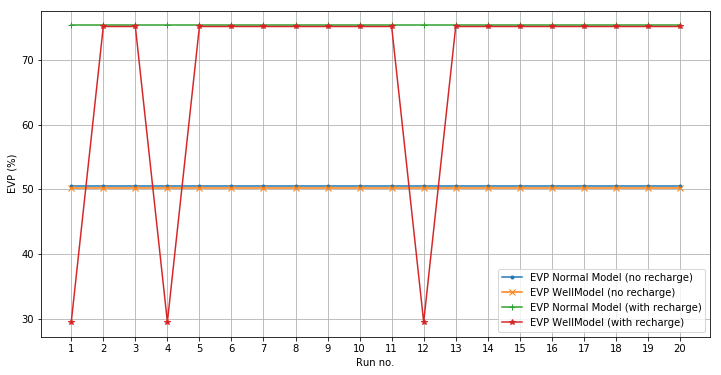

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(range(1, N+1), results0.values, label="EVP Normal Model (no recharge)", marker=".")
ax.plot(range(1, N+1), results1.values, label="EVP WellModel (no recharge)", marker="x")
ax.plot(range(1, N+1), results2.values, label="EVP Normal Model (with recharge)", marker="+")
ax.plot(range(1, N+1), results3.values, label="EVP WellModel (with recharge)", marker="*")
ax.grid(b=True)
ax.set_ylabel("EVP (%)")
ax.set_xticks(range(1, N+1))
ax.set_xlabel("Run no.")
ax.legend(loc="best");

True